In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import numpy as np
import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)

In [2]:
api = wandb.Api()
entity, project = "invariance-learners", "icml2024"  # set to your entity and project 

In [3]:
# create dict mapping sweep name to sweep id
sweep_id_dict = {
    "vae_sweep_000_50k_0": "lb99ocz5",
    "augvae_sweep_000_50k_0": "hkq3aebo",
}

In [4]:
summary_list, config_list, name_list, tags, ids, states, sweeps = [], [], [], [], [], [],  []

for sweep, sweep_id in sweep_id_dict.items():
    runs = api.sweep(entity + "/" + project + "/" + sweep_id).runs

    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        tags.append(run.tags)

        ids.append(run.id)

        states.append(run.state)

        sweeps.append(sweep)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states,
    "sweep": sweeps,
    })

runs_df

,summary,config,name,tags,id,state,sweep
0,"{'train/iwlb': None, 'train/loss': -1403.66198...","{'lr': 0.01, 'seed': 0, 'angle': 0, 'model': {...",valiant-sweep-288,[],wmd8u37c,finished,vae_sweep_000_50k_0
1,"{'train/kld': 63.20401382446289, 'valid/kld': ...","{'lr': 0.01, 'seed': 0, 'angle': 0, 'model': {...",fine-sweep-286,[],irku07pl,finished,vae_sweep_000_50k_0
2,"{'train/ll': 1463.04638671875, 'valid/ll': 113...","{'lr': 0.01, 'seed': 0, 'angle': 0, 'model': {...",summer-sweep-287,[],le3ku8st,finished,vae_sweep_000_50k_0
3,"{'_runtime': 713.7999382019043, 'train/ll': 13...","{'lr': 0.01, 'seed': 0, 'angle': 0, 'model': {...",azure-sweep-285,[],tmwnuqra,finished,vae_sweep_000_50k_0
4,"{'valid/elbo': 1085.222900390625, 'β': 1, 'sam...","{'lr': 0.01, 'seed': 0, 'angle': 0, 'model': {...",expert-sweep-284,[],lxrytl2u,finished,vae_sweep_000_50k_0
...,...,...,...,...,...,...,...
566,"{'valid/x_mse': 0.04660356044769287, '_step': ...","{'lr': 0.003, 'seed': 0, 'angle': 0, 'model': ...",noble-sweep-3,[],2yfjd3sp,finished,augvae_sweep_000_50k_0
567,"{'lr': 2.999999821895472e-07, '_step': 5000, '...","{'lr': 0.003, 'seed': 0, 'angle': 0, 'model': ...",elated-sweep-7,[],9rk0dowh,finished,augvae_sweep_000_50k_0
568,"{'valid/elbo': 905.9064331054688, 'gen_plots_0...","{'lr': 0.003, 'seed': 0, 'angle': 0, 'model': ...",still-sweep-6,[],vwzgdeqf,finished,augvae_sweep_000_50k_0
569,"{'train/elbo': 564.1812744140625, 'lr': 2.9999...","{'lr': 0.003, 'seed': 0, 'angle': 0, 'model': ...",upbeat-sweep-2,[],iste110i,finished,augvae_sweep_000_50k_0


In [5]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'sweep', 'summary.train/iwlb',
       'summary.train/loss', 'summary.valid/elbo', 'summary._step',
       'summary.valid/kld', 'summary.train/ll', 'summary.valid/iwlb',
       'summary.valid/ll', 'summary._timestamp', 'summary.train/elbo',
       'summary.lr', 'summary.train/kld', 'summary.valid/loss',
       'summary.train/x_mse', 'summary.valid/x_mse', 'summary.β',
       'summary._runtime', 'summary._wandb.runtime', 'summary.sample.path',
       'summary.sample.size', 'summary.sample._type', 'summary.sample.width',
       'summary.sample.format', 'summary.sample.height',
       'summary.sample.sha256', 'summary.recon.width', 'summary.recon.format',
       'summary.recon.height', 'summary.recon.sha256', 'summary.recon.path',
       'summary.recon.size', 'summary.recon._type',
       'summary.inf_plots_0.format', 'summary.inf_plots_0.height',
       'summary.inf_plots_0.sha256', 'summary.inf_plots_0.path',
       'summary.inf_plots_0.size', 'summa

In [6]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] != 'failed']

# take only runs with certain tags
# tags_to_keep = ['angle_sweep', 'num_trn_sweep', 'mnist', 'vae']
# df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
# tags_to_remove = ['test', 'hidden', 'ssilvae']
# df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

# replace nans in config.num_trn and config.angle with -1
df_filtered['config.num_trn'] = df_filtered['config.num_trn'].fillna(-1)
df_filtered['config.angle'] = df_filtered['config.angle'].fillna(0)

df_filtered

,name,tags,id,state,sweep,summary.train/iwlb,summary.train/loss,summary.valid/elbo,summary._step,summary.valid/kld,summary.train/ll,summary.valid/iwlb,summary.valid/ll,summary._timestamp,summary.train/elbo,summary.lr,summary.train/kld,summary.valid/loss,summary.train/x_mse,summary.valid/x_mse,summary.β,summary._runtime,summary._wandb.runtime,summary.sample.path,summary.sample.size,summary.sample._type,summary.sample.width,summary.sample.format,summary.sample.height,summary.sample.sha256,summary.recon.width,summary.recon.format,summary.recon.height,summary.recon.sha256,summary.recon.path,summary.recon.size,summary.recon._type,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_0.width,summary.gen_plots_1.path,summary.gen_plots_1.size,summary.gen_plots_1._type,summary.gen_plots_1.width,summary.gen_plots_1.format,summary.gen_plots_1.height,summary.gen_plots_1.sha256,summary.gen_plots_0._type,summary.gen_plots_0.width,summary.gen_plots_0.format,summary.gen_plots_0.height,summary.gen_plots_0.sha256,summary.gen_plots_0.path,summary.gen_plots_0.size,summary.inf_plots_1.path,summary.inf_plots_1.size,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,config.lr,config.seed,config.angle,config.steps,config.dataset,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.run_iwlb,config.clip_norm,config.eval_freq,config.plot_freq,config.val_split,config.batch_size,config.model_name,config.train_split,config.init_lr_mult,config.weight_decay,config.final_lr_mult,config.batch_size_eval,config.iwlb_num_samples,config.warmup_steps_pct,config.shuffle_buffer_size,config.repeat_after_batching,config.β_schedule_init_value,config.β_schedule_final_value,config.model.conv_dims,config.model.dense_dims,config.model.latent_dim,config.test_split
0,valiant-sweep-288,[],wmd8u37c,finished,vae_sweep_000_50k_0,None,-1403.661987,1044.174805,20000,65.387306,1468.970581,None,1109.562012,1.703084e+09,1403.661987,1.000000e-04,65.309128,-1044.174805,0.017379,0.022498,1,1347.837138,1347,media/images/sample_19999_b39b71c1c0d18ce141bd...,40784,image-file,4000,png,200,b39b71c1c0d18ce141bd6e1a24f031e63f974dec4bf4d9...,4000,png,400,8fefb1b7275ada72d1cdeaf4bfa5f846c8c7ecfa807950...,media/images/recon_19999_8fefb1b7275ada72d1cd.png,44972,image-file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010,0,0,20000,MNIST,50000,10000,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",preprocessed,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",False,2,0.01,0.25,train[:10000],512,VAE,train[10000:60000],0.1,0.0001,0.0100,50,300,0.2,50000,True,1,1,"64,128,256",128,20,NaN
1,fine-sweep-286,[],irku07pl,finished,vae_sweep_000_50k_0,None,-1326.677124,1115.701294,10000,63.226410,1389.880615,None,1178.927368,1.703083e+09,1326.677124,1.000000e-04,63.204014,-1115.701294,0.018728,0.022262,1,698.608387,698,media/images/sample_9999_166d096607c792b1537f.png,41683,image-file,4000,png,200,166d096607c792b1537f8b939025b287b44354d9de3926...,4000,png,400,684a6bf2e126cfd47fae9a13b936c18907c58188d7016c...,media/images/recon_9999_684a6bf2e126cfd47fae.png,45987,image-file,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010,0,0,10000,MNIST,50000,10000,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",preprocessed,"value_range(-1, 1)|random_rotate(-0, 0, fill_v...",False,2,0.01,0.25,train[:10000],512,VAE,train[10000:60000],0.1,0.0001,0.0100,50,300,0.2,50000,True,1,1,"64,128,256",128,20,NaN
2,summer-sweep-287,[],le3ku8st,finished,vae_sweep_000_50k_0,None,-1397.221191,1066.169800,20000,65.864586,1463.046387,None,1132.034302,1.703084e+09,1397.221191,1.000000e-04,65.825142,-1066.169800,0.017381,0.022153,1,1352.367252,1351,media/images/sample_19999_

In [7]:
df_filtered['config.angle'].unique()

array([0])

In [8]:
df_filtered['config.steps'].unique()

array([20000, 10000,  5000])

In [9]:
df_filtered['config.num_trn'].unique()

array([50000])

In [10]:
df_filtered['config.dataset'].unique()

array(['MNIST'], dtype=object)

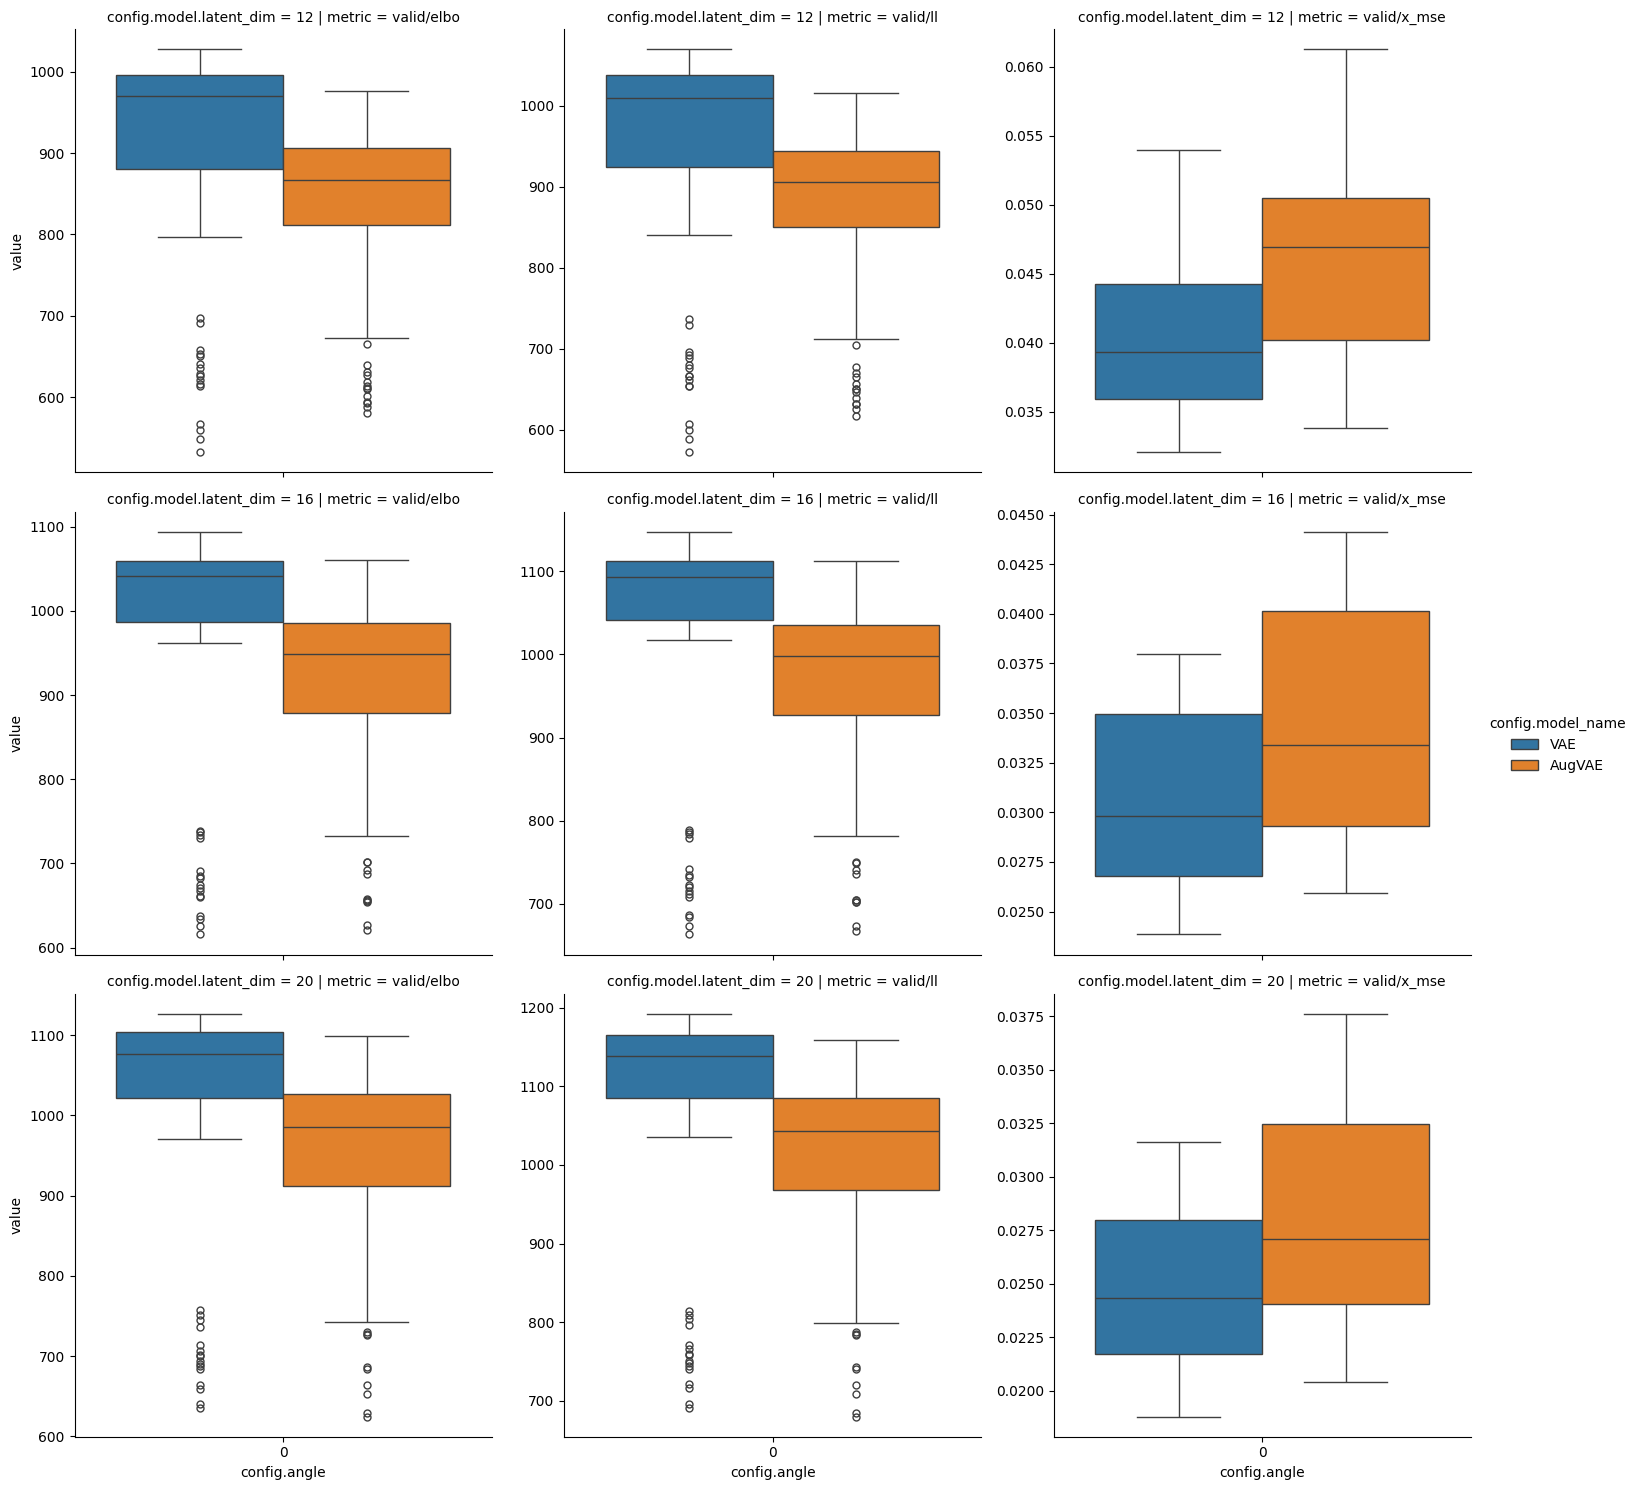

In [17]:
# pivot the data frame so that each of metrics is a column, and the values are the corresponding values
plot_df = df_filtered.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.model_name', 'config.model.latent_dim'],
    value_vars=['summary.valid/elbo', 'summary.valid/ll', 'summary.valid/x_mse'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')


sns.catplot(data=plot_df, x="config.angle", y="value", col="metric", row='config.model.latent_dim', hue='config.model_name', kind="box", showfliers=True, sharey=False)